# 1. Introduction  
This work was inspired by Maury Lukas' "Helping people in Lisbon to predict Airbnb prices" (https://www.kaggle.com/code/maurylukas/helping-people-in-lisbon-to-predict-airbnb-prices) and by Allan Bruno's "Helping regular people price listings on AirBnb" (https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb)

The goal was to create a price prediction model to be integrated in the PropertEase price recommendation feature. This Kaggle focus solely on the price prediction and has some differences from the process adopted for PropertEase.

The analysis was made using 2021 Airbnb data available in http://insideairbnb.com/get-the-data.html  

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pathlib as pl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

# 2. Initial Data Analysis  
Here data info will be displayed to better understand what we're working with.

In [63]:
path = pl.Path(f"./data/21")

months = {"mar": 0, "jun": 1, "sep": 2, "dec": 3}

dfraw21 = pd.DataFrame()
for file in path.iterdir():
    df = pd.read_csv(path/file.name)
    df=df.dropna(subset=['price'])
    df["price"] = df["price"].apply(lambda x: x.replace("$",""))
    df ["price"] = df ["price"].apply(lambda x: x.replace(",",""))
    df ["price"] = df ["price"].astype (np.float32)
    df ["price"] = df ["price"].astype (np.int32)
    #df["month"] = months[file.name[:3]]
    dfraw21 = pd.concat([dfraw21,df])

#dfraw = dfraw21

path = pl.Path(f"./data/23")
dfraw23 = pd.DataFrame()
for file in path.iterdir():
    df = pd.read_csv(path/file.name)
    df=df.dropna(subset=['price'])
    df["price"] = df["price"].apply(lambda x: x.replace("$",""))
    df ["price"] = df ["price"].apply(lambda x: x.replace(",",""))
    df ["price"] = df ["price"].astype (np.float32)
    df ["price"] = df ["price"].astype (np.int32)
    #df["month"] = months[file.name[:3]]
    dfraw23 = pd.concat([dfraw23,df])

path = pl.Path(f"./data/porto")
dfPorto = pd.DataFrame()
for file in path.iterdir():
    df = pd.read_csv(path/file.name)
    df=df.dropna(subset=['price'])
    df["price"] = df["price"].apply(lambda x: x.replace("$",""))
    df ["price"] = df ["price"].apply(lambda x: x.replace(",",""))
    df ["price"] = df ["price"].astype (np.float32)
    df ["price"] = df ["price"].astype (np.int32)
    #df["month"] = months[file.name[:3]]
    dfPorto = pd.concat([dfPorto,df])
dfPorto = dfPorto.drop("source",axis=1)
dfraw = dfraw23
dfraw = pd.concat([dfraw21, dfraw23])

In [64]:
# path = pl.Path (f"archive")
# df_list = [] 

# for file in path.iterdir():
#     df_list.append(pd.read_csv(file))

# dfraw = pd.concat(df_list, ignore_index=True)

In [65]:
dfraw.info ()
dfPorto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162277 entries, 0 to 22928
Data columns (total 75 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            162277 non-null  int64  
 1   listing_url                                   162277 non-null  object 
 2   scrape_id                                     162277 non-null  int64  
 3   last_scraped                                  162277 non-null  object 
 4   name                                          162240 non-null  object 
 5   description                                   140057 non-null  object 
 6   neighborhood_overview                         101264 non-null  object 
 7   picture_url                                   162277 non-null  object 
 8   host_id                                       162277 non-null  int64  
 9   host_url                                      162277 n

Dropping all columns regarding:  
- IDs, URLs, dates, licenses, availabilities, names and descriptions, except for bathrooms text;  
- host data, except for if it's a superhost and its total listings count at the end, since verified status comes with the reviews;  
- locations, except for latitude and longitude;  
- property type, since it's already embedded in room type;  
- nights quantities, except for minimum nights.

In [66]:
dfraw.drop (dfraw.iloc [:, 0 : 17], axis = 1, inplace = True)
#dfraw.drop (dfraw.iloc [:, 0 : 18], axis = 1, inplace = True)
dfraw.drop (dfraw.iloc [:, 1 : 12], axis = 1, inplace = True)
dfraw.drop (dfraw.iloc [:, 13 : 27], axis = 1, inplace = True)

dfPorto.drop (dfPorto.iloc [:, 0 : 17], axis = 1, inplace = True)
#dfPorto.drop (dfPorto.iloc [:, 0 : 18], axis = 1, inplace = True)
dfPorto.drop (dfPorto.iloc [:, 1 : 12], axis = 1, inplace = True)
dfPorto.drop (dfPorto.iloc [:, 13 : 27], axis = 1, inplace = True)

In [67]:
dfraw.isnull ().sum ()

host_is_superhost                                 5972
latitude                                             0
longitude                                            0
property_type                                        0
room_type                                            0
accommodates                                         0
bathrooms                                       142256
bathrooms_text                                     193
bedrooms                                         35200
beds                                              1829
amenities                                            0
price                                                0
minimum_nights                                       0
number_of_reviews                                    0
number_of_reviews_ltm                                0
number_of_reviews_l30d                               0
first_review                                     23229
last_review                                      23229
review_sco

Drop missing values.

In [68]:
dfraw.drop (dfraw.iloc [:, 14 : 26], axis = 1, inplace = True)
dfraw.drop (dfraw.iloc [:, 16 : 20], axis = 1, inplace = True)
dfraw = dfraw.drop ("property_type", axis = 1)
if "source" in dfraw:
    dfraw = dfraw.drop("source", axis = 1)

dfPorto.drop (dfPorto.iloc [:, 14 : 26], axis = 1, inplace = True)
dfPorto.drop (dfPorto.iloc [:, 16 : 20], axis = 1, inplace = True)
dfPorto = dfPorto.drop ("property_type", axis = 1)
if "source" in dfPorto:
    dfPorto = dfPorto.drop("source", axis = 1)

In [69]:
dfraw['bathrooms'] = dfraw['bathrooms_text'].str.extract("(\d*\.?\d+)", expand=False)
dfraw['bathrooms'] = np.where(dfraw['bathrooms_text'].str.contains("half", case=False, na=False), 0.5, dfraw['bathrooms'])
dfraw = dfraw.dropna ()
df = dfraw.drop ("bathrooms_text", axis = 1)

dfPorto['bathrooms'] = dfPorto['bathrooms_text'].str.extract("(\d*\.?\d+)", expand=False)
dfPorto['bathrooms'] = np.where(dfPorto['bathrooms_text'].str.contains("half", case=False, na=False), 0.5, dfPorto['bathrooms'])
dfPorto = dfPorto.dropna ()
dfPorto = dfPorto.drop ("bathrooms_text", axis = 1)

# 3. Exploratory Data Analysis  
Remove some outliers.  

In [70]:
df.dtypes

host_is_superhost                  object
latitude                          float64
longitude                         float64
room_type                          object
accommodates                        int64
bathrooms                          object
bedrooms                          float64
beds                              float64
amenities                          object
price                               int32
minimum_nights                      int64
number_of_reviews                   int64
instant_bookable                   object
calculated_host_listings_count      int64
dtype: object

Transform to numbers and 64 to 32.

In [71]:
df ["accommodates"] = df ["accommodates"].astype (np.int32, copy = False)
df ["bedrooms"] = df ["bedrooms"].astype (np.int32, copy = False)
df ["beds"] = df ["beds"].astype (np.int32, copy = False)
df ["minimum_nights"] = df ["minimum_nights"].astype (np.int32, copy = False)
df ["number_of_reviews"] = df ["number_of_reviews"].astype (np.int32, copy = False)
df ["calculated_host_listings_count"] = df ["calculated_host_listings_count"].astype (np.int32, copy = False)
df ["latitude"] = df ["latitude"].astype (np.float32, copy = False)
df ["longitude"] = df ["longitude"].astype (np.float32, copy = False)
df ["bathrooms"] = df ["bathrooms"].astype (np.float32, copy = False)

dfPorto ["accommodates"] = dfPorto ["accommodates"].astype (np.int32, copy = False)
dfPorto ["bedrooms"] = dfPorto ["bedrooms"].astype (np.int32, copy = False)
dfPorto ["beds"] = dfPorto ["beds"].astype (np.int32, copy = False)
dfPorto ["minimum_nights"] = dfPorto ["minimum_nights"].astype (np.int32, copy = False)
dfPorto ["number_of_reviews"] = dfPorto ["number_of_reviews"].astype (np.int32, copy = False)
dfPorto ["calculated_host_listings_count"] = dfPorto ["calculated_host_listings_count"].astype (np.int32, copy = False)
dfPorto ["latitude"] = dfPorto ["latitude"].astype (np.float32, copy = False)
dfPorto ["longitude"] = dfPorto ["longitude"].astype (np.float32, copy = False)
dfPorto ["bathrooms"] = dfPorto ["bathrooms"].astype (np.float32, copy = False)

We'll use the function that statistically define outliers using interquartile range, and some graphical functions to identify which room types there are and how prices are distributed throughout the dataframe:

/home/tomas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



room_type
Entire home/apt    0.830351
Private room       0.149223
Shared room        0.016374
Hotel room         0.004051
Name: proportion, dtype: float64

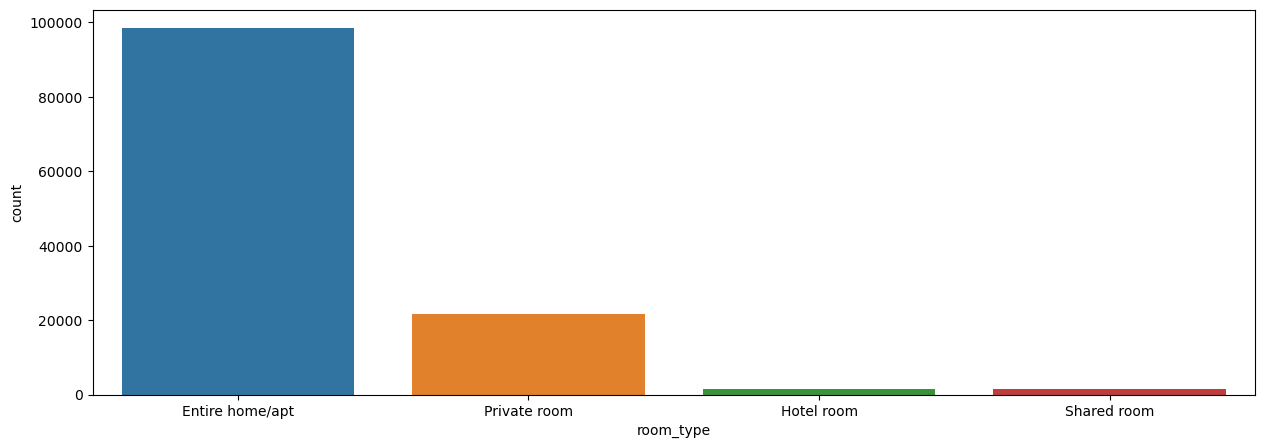

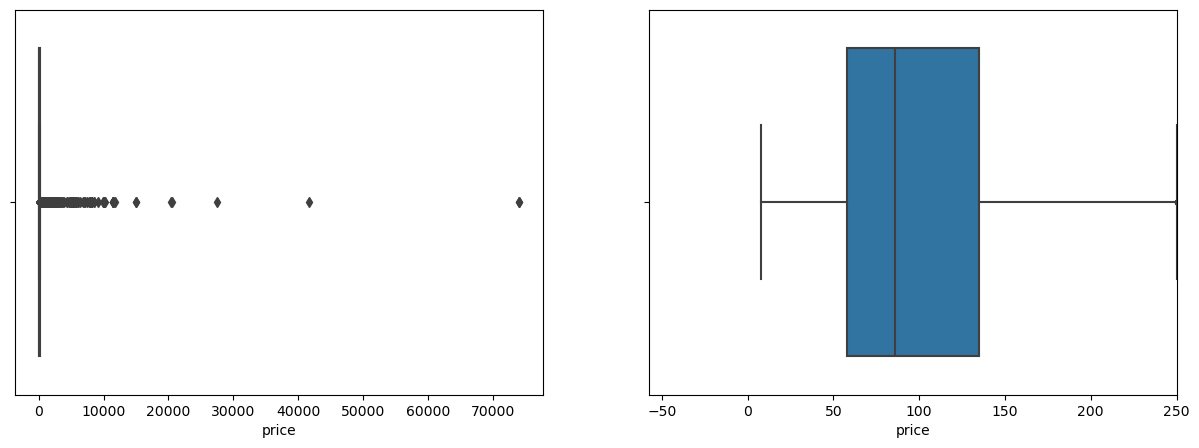

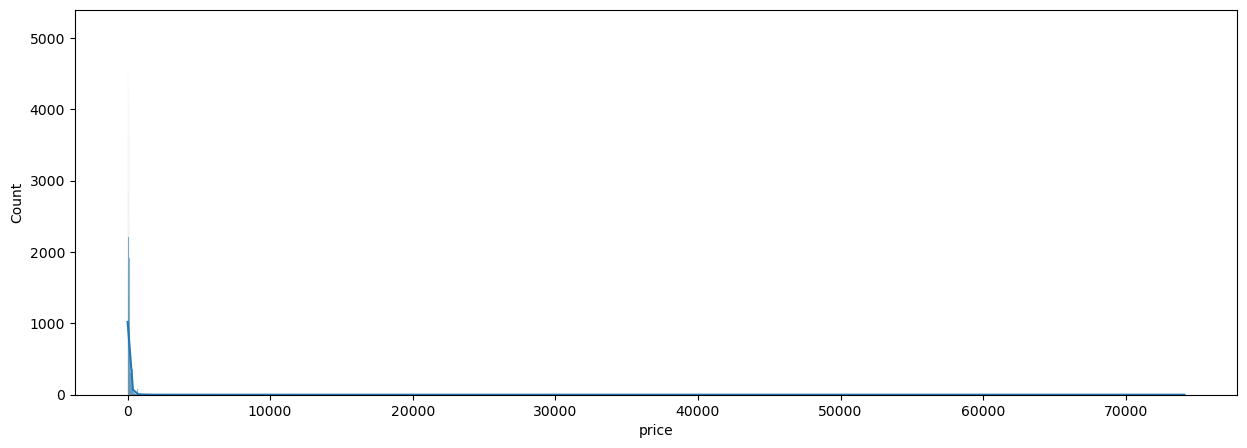

In [72]:
def outlier (col):
    q1 = col.quantile (0.25)
    q3 = col.quantile (0.75)
    iqr = q3 - q1
    lenght = 1.5
    return q1 - lenght * iqr, q3 + lenght * iqr

def box (col):
    fig, (ax1, ax2) = plt.subplots (1, 2)
    fig.set_size_inches (15, 5)
    sns.boxplot (x = col, ax = ax1)
    ax2.set_xlim (outlier (col))
    sns.boxplot (x = col, ax = ax2)

def hist (col):
    plt.figure (figsize = (15,5))
    sns.histplot (col, kde = True)

def bar (col):
    plt.figure (figsize = (15,5))
    ax = sns.barplot (x = col.value_counts ().index, y = col.value_counts ())
    if col.dtypes != "object":
        ax.set_xlim (outlier (col))
        
bar (df ["room_type"])
box (df ["price"])
hist (df ["price"])
df ["room_type"].value_counts (normalize = True)

dfPorto ["room_type"].value_counts (normalize = True)

Remove anomalies.

895 rows removed


/home/tomas/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



114162 total rows and 14 total columns


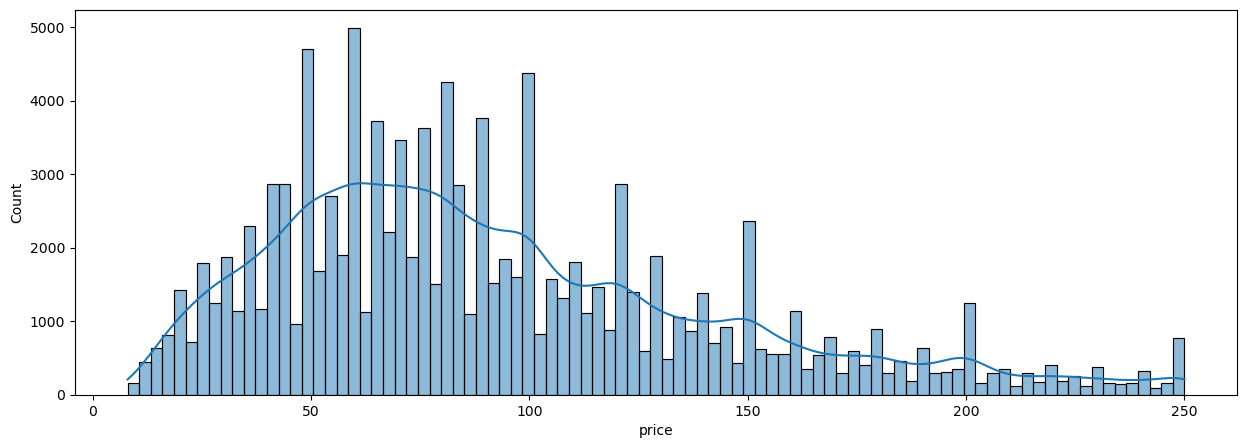

In [73]:
def remove (ds, col):
    before = ds.shape [0]
    low, up = outlier (ds [col])
    ds = ds.loc [(ds [col] >= low) & (ds [col] <= up), :]
    return ds, before - ds.shape [0]
df, removed = remove (df, "price")

aux = df ["room_type"].value_counts ()
for kind in aux.index:
    if aux [kind] < 15000:
        df.loc [df ["room_type"] == kind, "room_type"] = "Rooms"

dfPorto, removed = remove (dfPorto, "price")

aux = dfPorto ["room_type"].value_counts ()
for kind in aux.index:
    if aux [kind] < 15000:
        dfPorto.loc [dfPorto ["room_type"] == kind, "room_type"] = "Rooms"
        
print (f"{removed} rows removed")
hist (df ["price"])
print (f"{df.shape [0]} total rows and {df.shape [1]} total columns")

Almost 10% of the data were removed and that's enough discrepancies out of the equation.  
All amenities will be counted instead of compared with each other individually.   
We can also view how prices are distributed geographically with a density mapbox (might not work in all envs):

In [74]:
df ["qty"] = df ["amenities"].str.split (",").apply (len)
df ["qty"] = df ["qty"].astype (np.int32, copy = False)

dfPorto ["qty"] = dfPorto ["amenities"].str.split (",").apply (len)
dfPorto ["qty"] = dfPorto ["qty"].astype (np.int32, copy = False)
display (df)
px.density_mapbox (df, lat = "latitude", lon = "longitude", z = "price", radius = 2.5, center = {"lat": df.latitude.mean (), "lon": df.longitude.mean ()}, zoom = 10, mapbox_style = "stamen-terrain").show ()

host_is_superhost   latitude  longitude        room_type  accommodates  \
0                     f  38.697498   -9.19768  Entire home/apt             4   
1                     t  38.712410   -9.12706  Entire home/apt             3   
2                     f  38.710819   -9.12719  Entire home/apt             4   
3                     t  38.711559   -9.12987  Entire home/apt             4   
6                     f  38.764271   -9.15301     Private room             6   
...                 ...        ...        ...              ...           ...   
22924                 t  38.799339   -9.38635  Entire home/apt             6   
22925                 f  38.806969   -9.38074     Private room             2   
22926                 t  38.726822   -9.16208  Entire home/apt             3   
22927                 t  38.798481   -9.41690  Entire home/apt             2   
22928                 f  38.757439   -9.09450  Entire home/apt             5   

       bathrooms  bedrooms  beds  \
0            1.0         1     1   
1            1.0         1     1   
2            1.0         1     2   
3            1.0         1     1   
6            2.0         1     3   
...          ...       ...   ...   
22924        1.0         3     3   
22925        1.0         1     1   
22926        1.0         1     1   
22927        1.0         1     1   
22928        2.0         2     2   

                                               amenities  price  \
0      ["Dishwasher", "Cooking basics", "Refrigerator...     40   
1      ["Cooking basics", "Smoke alarm", "Refrigerato...     50   
2      ["Hair dryer", "Dishes and silverware", "Cooki...     60   
3      ["Cooking basics", "Refrigerator", "TV with st...     60   
6      ["Free parking on premises", "Heating", "TV wi...     40   
...                                                  ...    ...   
22924  ["Fire extinguisher", "Luggage dropoff allowed...     94   
22925    ["Kitchen", "Wifi", "Free parking on premises"]     64   
22926  ["TV", "Washer", "Bed linens", "Air conditioni...     95   
22927  ["Fire extinguisher", "Baking sheet", "Patio o...     60   
22928  ["Patio or balcony", "Luggage dropoff allowed"...    163   

       minimum_nights  number_of_reviews instant_bookable  \
0                   3                 32                t   
1                   2                127                t   
2                   5                337                t   
3                   2                299                t   
6                   1                  2                f   
...               ...                ...              ...   
22924               2                284                f   
22925               1                  1                t   
22926               3                 68                t   
22927               1                145                t   
22928               2                 30                f   

       calculated_host_listings_count  qty  
0                                   1   36  
1                                   1   27  
2                                   1   18  
3                                   1   26  
6                                   2   10  
...                               ...  ...  
22924                               1   48  
22925                              27    3  
22926                              20   34  
22927                               3   47  
22928                               3   47  

[114162 rows x 15 columns]

# 4. Encoding and Modeling  
Drop unnecessary columns.

In [ ]:
dfenc = df.drop ("amenities", axis = 1)
dfenc = dfenc.drop ("host_is_superhost", axis = 1)
dfenc = dfenc.drop ("instant_bookable", axis = 1)
dfenc ["room_type"] = np.where (dfenc ["room_type"] == "Rooms", 0, 1)

dfPorto = dfPorto.drop ("amenities", axis = 1)
dfPorto = dfPorto.drop ("host_is_superhost", axis = 1)
dfPorto = dfPorto.drop ("instant_bookable", axis = 1)
dfPorto ["room_type"] = np.where (dfPorto ["room_type"] == "Rooms", 0, 1)

The function "evaluate" will return three evaluation methods: Root mean squared error; Mean absolute error; and R² score.    
After that we'll start the regression models, split the data into 80% for training and 20% for testing, and run the models to compare which one.

In [76]:
def evaluate (model, ytest, prediction):
    rmse = np.sqrt (mean_squared_error (ytest, prediction))
    mae = mean_absolute_error (ytest, prediction)
    r2 = r2_score (ytest, prediction)
    return f"\n-----\nModel: {model}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2%}\n-----\n"

models = {'Random Forest': RandomForestRegressor (),
          'Decision Tree': DecisionTreeRegressor (),
          'Extra Trees': ExtraTreesRegressor ()
          }

ytrain = dfenc ["price"]
xtrain = dfenc.drop ("price", axis = 1)

ytest = dfPorto ["price"]
xtest = dfPorto.drop ("price", axis = 1)
#xtrain, xtest, ytrain, ytest = train_test_split (x, y, train_size=0.8)

for name, model in models.items ():
    model.fit (xtrain, ytrain)
    prediction = model.predict (xtest)
    print (evaluate (name, ytest, prediction))


-----
Model: Random Forest
RMSE: 39.33
MAE: 32.05
R2: -51.46%
-----


-----
Model: Decision Tree
RMSE: 63.44
MAE: 48.80
R2: -294.01%
-----


-----
Model: Extra Trees
RMSE: 33.53
MAE: 27.42
R2: -10.10%
-----

